In [1]:
class Location():
    
    def __init__(self, x=1, y=1):
        self.x = x
        self.y = y
        self.location = (self.x,self.y) 

In [2]:
class NaiveAgent():
    def __init__(self):
        self.agent_type = 'naive_agent'
        self.all_actions = ['forward', 'turn_left', 'turn_right', 'grab','shoot', 'climb']
        self.legal_actions = self.all_actions
        self.latest_percept = None
        self.score = None
        
    def next_action(self):
        import random
        return random.choice(self.legal_actions)
    
    def perceive(self, percept):
        self.latest_percept = percept
    

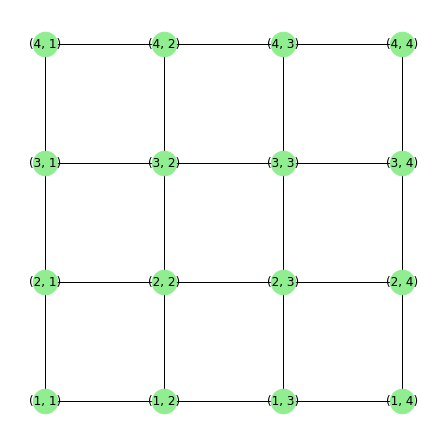

In [3]:
import networkx as nx
from matplotlib import pyplot as plt

G = nx.grid_2d_graph(range(1,5), range(1,5))

plt.figure(figsize=(6,6))
pos = {(x,y):(y,x) for x,y in G.nodes()}
nx.draw(G, pos=pos, 
        node_color='lightgreen', 
        with_labels=True,
        node_size=600)

Graph with 13 nodes and 16 edges


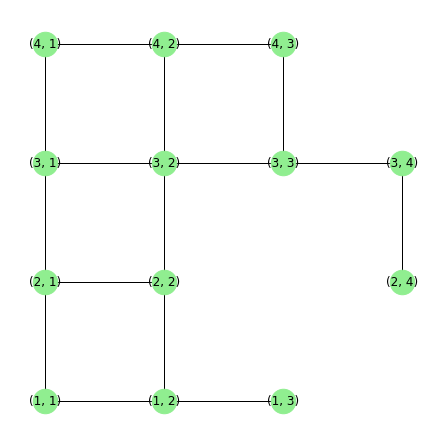

In [4]:
failed_nodes = [(1,4), (2,3), (4,4)]#change to remove locations that are not safe
G2=G
G2.remove_nodes_from(failed_nodes) #Failed_node_dict holds the disrupted nodes
print(G2)
plt.figure(figsize=(6,6))
pos = {(x,y):(y,x) for x,y in G2.nodes()}
nx.draw(G2, pos=pos, 
        node_color='lightgreen', 
        with_labels=True,
        node_size=600)

In [9]:
G2.nodes

NodeView(((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3)))

In [11]:
(3,3) in G2.nodes

True

In [17]:
start_node = (4,2)
end_node = (1,1)

In [18]:
nx.astar_path(G2, start_node, end_node)

[(4, 2), (3, 2), (2, 2), (1, 2), (1, 1)]

In [5]:
class BeelineAgent():
    def __init__(self):
        self.agent_type = 'beeline_agent'
        self.actions = ['forward', 'turn_left', 'turn_right']
        #,'shoot']  
        self.latest_percept = []
        self.has_gold = False
        self.score = None
        self.agent_loc = Location(1,1)
        self.orientation = 'RIGHT'
        self.safe_locations = []
        self.latest_action = None
        self.grid = 4
        self.graph = 
        
    def next_action(self):
        import random
        if 'glitter' in self.latest_percept and not self.has_gold:
            self.has_gold = True
            self.latest_action = 'grab'
            from termcolor import colored

            print(colored("FOUND GOLD! FOUND GOLD! FOUND GOLD!", 'red'))
        elif self.has_gold and self.agent_loc.x==1 and self.agent_loc.y==1:
            self.latest_action = 'climb'
        else:
            self.latest_action = random.choice(self.actions)
            self.track_location()
        print(self.latest_action)
        print(f"Agent Location x: {self.agent_loc.x},y: {self.agent_loc.y}")
        return self.latest_action
      
        
    def track_location(self):
        if self.latest_action == 'forward':
                if self.orientation == 'RIGHT':
                    if  self.agent_loc.x < self.grid:
                        self.agent_loc.x += 1
                    else:
                        self.bump = True
                elif self.orientation == 'UP':
                    if self.agent_loc.y < self.grid:
                        self.agent_loc.y += 1
                    else:
                        self.bump = True

                elif self.orientation == 'LEFT':
                    if self.agent_loc.x > 1:
                        self.agent_loc.x -= 1
                    else:
                        self.bump = True

                elif self.orientation == 'DOWN':
                    if self.agent_loc.y > 1:
                        self.agent_loc.y -= 1
                    else:
                         self.bump = True
                safe_location = (self.agent_loc.x,self.agent_loc.y)
                if safe_location not in self.safe_locations:
                    self.safe_locations.append(safe_location)
                    #print(self.safe_locations)

        if self.latest_action == 'turn_left':
            if self.orientation == 'RIGHT':
                self.orientation = 'UP'
            elif self.orientation == 'UP':
                self.orientation = 'LEFT'
            elif self.orientation == 'LEFT':
                self.orientation = 'DOWN'
            elif self.orientation == 'DOWN':
                self.orientation = 'RIGHT'

        if self.latest_action == 'turn_right':
            if self.orientation == 'RIGHT':
                self.orientation = 'DOWN'
            elif self.orientation == 'UP':
                self.orientation = 'RIGHT'
            elif self.orientation == 'LEFT':
                self.orientation = 'UP'
            elif self.orientation == 'DOWN':
                self.orientation = 'LEFT'

    
    def perceive(self, percept):
        self.latest_percept = percept
   
    
#     def path_back(self):
#         if self.has_gold:
            


In [6]:
class WumpusEnvironment():
    
    
    def __init__(self, width = 4, height = 4, allow_climb_without_gold= True, pit_prob = 0):
       
        self.grid_size = (width,height)
        self.grid = width
        self.x_start, self.y_start = (1, 1)
        self.x_end, self.y_end = (self.grid,self.grid)
        self.pit_prob = pit_prob
        self.allow_climb_without_gold = allow_climb_without_gold
        self.agent_loc = Location(self.x_start, self.y_start)
        self.agent_loc.x,self.agent_loc.y=self.agent_loc.x, self.agent_loc.y
        self.orientation = 'RIGHT'
        self.agent_alive = True
        self.agent_has_arrow = True
        self.agent_has_gold = False
        self.wumpus_alive = True
        self.scream = False
        self.make_things()
        self.make_percepts()
        self.wumpus_location = self.thing_position('wumpus')
        self.game_over = False
        self.score=0
        self.bump = False

        
    def make_things(self) -> tuple[dict,list,tuple]:
        from itertools import product
        import random
        self.cells =list(product((list(range(1,5))),repeat=2))
        self.things =  {key: [] for key in self.cells}
        self.pits = []

        
#create pits:
        for x in range(self.x_start, self.x_end + 1):
            for y in range(self.y_start, self.y_end+1):
                if (x != 1) or (y != 1):
                    if random.random() < self.pit_prob:
                        self.pits.append((x, y))
                        self.things[(x,y)].append('pit')
        
        
#create wumpus
        self.wumpus=(random.randint(self.x_start, self.x_end), random.randint(self.y_start, self.y_end))
        while self.wumpus==(self.x_start,self.y_start):
            self.wumpus=(random.randint(self.x_start, self.x_end), random.randint(self.y_start, self.y_end))
        self.things[self.wumpus].append('wumpus')
        
                    
        #create gold:
        self.gold=(random.randint(self.x_start, self.x_end), random.randint(self.y_start, self.y_end))
        while self.gold==(self.x_start,self.y_start):
            self.gold=(random.randint(self.x_start, self.x_end), random.randint(self.y_start, self.y_end))
        self.things[self.gold].append('gold')
             
        return self.things,self.pits, self.wumpus,self.gold
    

#to find location of wumpus and gold:
    def thing_position(self,thing) -> tuple:
        keys=list(self.things.keys())
        values=list(self.things.values())

        try:
            values.index([thing])
            position = values.index([thing])
        except:
            try: 
                for sublist in values:
                    if thing in sublist:
                        position = values.index(sublist)
            except:
                print('exception ocurred')
        return (keys[position])
    
            
        
#create percepts
    def same_loc (self,loc1, loc2) -> bool:
        return loc1[0] == loc2[0] and loc1[1] == loc2[1]
    
    
    def is_adjacent(self,loc1, loc2) -> bool:
        x1 = loc1[0]
        x2 = loc2[0]
        y1 = loc1[1]
        y2 = loc2[1]

        if (x1 == x2) and (y1 == (y2 - 1)) or \
           (x1 == x2) and (y1 == (y2 + 1)) or \
           (x1 == (x2 - 1)) and (y1 == y2) or \
           (x1 == (x2 + 1)) and (y1 == y2):
            return True
        return False
    
    
    def make_percepts(self) -> dict: 
        self.percepts = {key: [] for key in self.cells}
        for cell in self.percepts.keys():
            for pit in self.pits:
                if  self.is_adjacent(cell, pit) and 'breeze' not in self.percepts[cell]:
                    self.percepts[cell].append('breeze')


            if self.is_adjacent(cell,self.wumpus)or self.same_loc(cell,self.wumpus):
                self.percepts[cell].append('stench')

            if self.same_loc(cell,self.gold):
                self.percepts[cell].append('glitter')
        return self.percepts
        
    
#pass percepts to an agent for the cell it's in:    
    def get_percepts_and_score(self) -> list:
        import copy
        temp_percepts = copy.deepcopy(self.percepts[(self.agent_loc.x, self.agent_loc.y)])
        if self.bump:
            temp_percepts.append('bump')
            self.bump = False
        
        elif self.scream:
            temp_percepts.append('scream')
            self.scream = False
        temp_percepts.append(self.score)
        
       
        return temp_percepts


#to track how agent's actions affect the environment:
    def take_action(self,action):

            if action == 'forward':
                if self.orientation == 'RIGHT':
                    if  self.agent_loc.x < self.grid:
                        self.agent_loc.x += 1
                    else:
                        self.bump = True
                elif self.orientation == 'UP':
                    if self.agent_loc.y < self.grid:
                        self.agent_loc.y += 1
                    else:
                        self.bump = True

                elif self.orientation == 'LEFT':
                    if self.agent_loc.x > 1:
                        self.agent_loc.x -= 1
                    else:
                        self.bump = True

                elif self.orientation == 'DOWN':
                    if self.agent_loc.y > 1:
                        self.agent_loc.y -= 1
                    else:
                         self.bump = True      


            if action == 'turn_left':
                if self.orientation == 'RIGHT':
                    self.orientation = 'UP'
                elif self.orientation == 'UP':
                    self.orientation = 'LEFT'
                elif self.orientation == 'LEFT':
                    self.orientation = 'DOWN'
                elif self.orientation == 'DOWN':
                    self.orientation = 'RIGHT'

            if action == 'turn_right':
                if self.orientation == 'RIGHT':
                    self.orientation = 'DOWN'
                elif self.orientation == 'UP':
                    self.orientation = 'RIGHT'
                elif self.orientation == 'LEFT':
                    self.orientation = 'UP'
                elif self.orientation == 'DOWN':
                    self.orientation = 'LEFT'

            
            if action == 'grab':
                if not self.agent_has_gold and (self.agent_loc.x, self.agent_loc.y)==self.thing_position('gold'):
                    self.agent_has_gold = True   
                else:
                    print("Illegal action 'GRAB'")

            if action == 'shoot':
                if  self.agent_has_arrow:
                    self.agent_has_arrow = False
                    self.score-=10

                    if self.wumpus_alive:
                        if (((self.orientation == 'RIGHT') and
                             (self.agent_loc.x < self.wumpus_location[0]) and
                             (self.agent_loc.y == self.wumpus_location[1])) or

                            ((self.orientation == 'UP') and
                             (self.agent_loc.x == self.wumpus_location[0]) and
                             (self.agent_loc.y < self.wumpus_location[1])) or

                            ((self.orientation == 'LEFT') and
                             (self.agent_loc.x > self.wumpus_location[0]) and
                             (self.agent_loc.y == self.wumpus_location[1])) or

                            ((self.orientation == 'DOWN') and
                             (self.agent_loc.x == self.wumpus_location[0]) and
                             (self.agent_loc.y > self.wumpus_location[1]))):
                            self.wumpus_alive = False
                            self.scream = True

                else:
                    print('No arrows!')



            if action == 'climb':
                if self.agent_loc.x == self.x_start and\
                self.agent_loc.y == self.y_start and\
                self.agent_has_gold:
                    self.score+=1000
                    self.end_of_round()
                
                else:
                    print('Illegal action! You cannot climb without gold or outside of start square!')
                    
            if  ((self.agent_loc.x, self.agent_loc.y)==self.wumpus_location and self.wumpus_alive) or \
                ((self.agent_loc.x, self.agent_loc.y) in self.pits):
                    self.agent_alive = False
                    self.score-=1000
                    print(f"You've encountered a {'pit' if (self.agent_loc.x, self.agent_loc.y) in self.pits else 'wumpus'}!")
                    self.end_of_round()
            self.score-=1
                
    def get_score(self):
        return self.score
       
    
    def end_of_round(self):
        #ALSO NEEDS TO CLIMB OUT:
        if self.agent_alive and self.agent_has_gold:
            print("Congratulations! You won!")        
        else:
            print('Wa-Wa-Wa-Waaa! You lose!')
        self.game_over = True
        print(f"Final score: {self.score}")
        return self.score, self.new_round()
        
    def new_round(self):     
        new_game= input("Do you want to play again? Y or N\n")
        if new_game in["Y","y"]:
            return self.__init__()
        else:
            print("Thank you for playing!") 
         
        
    def print_world(self):
        """ print_world: print the current wumpus world"""

        # print out the first horizontal line
        out = "+"
        for x in range(1, self.grid + 1):
            out += "---+"
        print(out)

        for y in range(self.grid, 0, -1):  
            out = "|"

            for x in range(1, self.grid + 1):
                if self.wumpus_location[0] == x and self.wumpus_location[1]==y:
                    if self.wumpus_alive:
                        out += "W"
                    else:
                        out += "M"   #dead wumpus is upside down
                else:
                    out += " "

                if not self.agent_has_gold and self.thing_position('gold')[0] == x and\
                self.thing_position('gold')[1] ==y:
                    out += "G"
                else:
                    out += " "

                _has_pit = False
                for pit in self.pits:
                    if pit[0] == x and pit[1]==y:
                        _has_pit = True
                if _has_pit:
                    out += "P"
                else:
                    out += " "

                out += "|"

            print(out)
            out = "|"
            
#print the agent:
            for x in range(1, self.grid + 1):
                if self.agent_alive and self.agent_loc.x == x and self.agent_loc.y == y:
                    if self.orientation == 'RIGHT':
                        out += " A>|"
                    elif self.orientation == 'UP':
                        out += " A^|"
                    elif self.orientation == 'LEFT':
                        out += " A<|"
                    else:
                        out += " Av|"
                else:
                    out += "   |"

            print(out)
            out = "+"

            # print out the final horizontal line
            for x in range(1, self.grid + 1):
                out += "---+"

            print(out)

#print the current percepts and score for the agent's location
        print(self.get_percepts_and_score())
        print()

In [7]:
def game_engine(agent=NaiveAgent(), env=WumpusEnvironment()):
    
    
    #since agent is random, we need a condition to break the while loop:
        
    if agent.agent_type=='naive_agent':
        max_moves = 40
        i=1
        print(env.things) #print locations of wumpus, gold and pits to ensure visualizations are correct
        
        while not env.game_over and i<=max_moves:
            
            env.print_world() #visualize current game state
            current_percept = env.get_percepts_and_score() 
            agent.perceive(current_percept)
            next_action=agent.next_action()
            print(f"Move {i}. Next action: {next_action}")
            env.take_action(next_action)
            i+=1
            if i==max_moves+1:   #reinitialize for the new round
                env.new_round()
                i=1            

        
    else:
        print(env.things)
        max_moves = 100
        i=1
        while not env.game_over  and i<=max_moves:
            env.print_world() 
            current_percept = env.get_percepts_and_score()
            agent.perceive(current_percept)
            next_action=agent.next_action()
            print(f"next action: {next_action}")
            env.take_action(next_action)
            i+=1
            if i==max_moves+1:   #reinitialize for the new round
                agent.__init__()
                env.new_round()
                i=1         

In [8]:
game_engine(BeelineAgent()) 

{(1, 1): [], (1, 2): [], (1, 3): [], (1, 4): [], (2, 1): [], (2, 2): ['gold'], (2, 3): [], (2, 4): [], (3, 1): [], (3, 2): [], (3, 3): [], (3, 4): ['wumpus'], (4, 1): [], (4, 2): [], (4, 3): [], (4, 4): []}
+---+---+---+---+
|   |   |W  |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   | G |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
| A>|   |   |   |
+---+---+---+---+
[0]

turn_left
Agent Location x: 1,y: 1
next action: turn_left
+---+---+---+---+
|   |   |W  |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   | G |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
| A^|   |   |   |
+---+---+---+---+
[-1]

turn_right
Agent Location x: 1,y: 1
next action: turn_right
+---+---+---+---+
|   |   |W  |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   | G |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   

Do you want to play again? Y or N
y
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |WG |   |
| A>|   |   |   |
+---+---+---+---+
[-1]

turn_left
Agent Location x: 3,y: 4
next action: turn_left
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |WG |   |
| A^|   |   |   |
+---+---+---+---+
[-2]

forward
Agent Location x: 3,y: 4
next action: forward
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
| A^|   |   |   |
+---+---+---+---+
|   |   |WG |   |
|   |   |   |   |
+---+---+---+---+
[-3]

turn_left
Agent Location x: 3,y: 4
next action: turn_left
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
| 

Do you want to play again? Y or N
y
+---+---+---+---+
|   |W  | G |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
| A>|   |   |   |
+---+---+---+---+
[0]

forward
Agent Location x: 2,y: 1
next action: forward
+---+---+---+---+
|   |W  | G |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   | A>|   |   |
+---+---+---+---+
[-1]

turn_right
Agent Location x: 2,y: 1
next action: turn_right
+---+---+---+---+
|   |W  | G |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   | Av|   |   |
+---+---+---+---+
[-2]

turn_right
Agent Location x: 2,y: 1
next action: turn_right
+---+---+---+---+
|   |W  | G |   |
|   |   |   |   |
+---+---+---+---+

KeyboardInterrupt: Interrupted by user